### AlexNet on ImageNette
Roger Wang  
UCLA  
  
AlexNet implementation on Imagenette dataset. Subset of ImageNet with 10 classes.  
  
Imagenette Github: https://github.com/fastai/imagenette

In [62]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from torch.optim import SGD
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
from PIL import Image

In [78]:
class Imagenette(Dataset):
    def __init__(self, train, root="../data/imagenette2-160", transform=None):
        self.trans = transform
        # if train or val dataset
        if train:
            root+="/train"
        else:
            root+="/val"
        
        # iterate over directory
        self.labels = os.listdir(root)
        self.images = np.array([])
        self.targets = np.array([])

        for n, label in enumerate(self.labels):
            sub = os.listdir(f'{root}/{label}')
            sub = [f'{root}/{label}/' + x for x in sub]
            self.images = np.concatenate((self.images,sub))
            self.targets = np.concatenate((self.targets,[n for x in range(len(sub))]))

    def __getitem__(self,idx):
        img = self.trans(Image.open(self.images[idx]).convert('RGB'))
        return img,self.targets[idx].astype('int')
    
    def __len__(self):
        return len(self.images)

In [79]:
# initialize datasets
path = "../data/imagenette2-160"
resize = (224,224)
trans = transforms.Compose([transforms.Resize(resize),transforms.ToTensor()])
train = Imagenette(True,transform=trans)
val = Imagenette(False,transform=trans)

In [80]:
# initialize dataloaders
batch = 128
trainloader = DataLoader(train,batch,True)
valloader = DataLoader(val,batch,False)

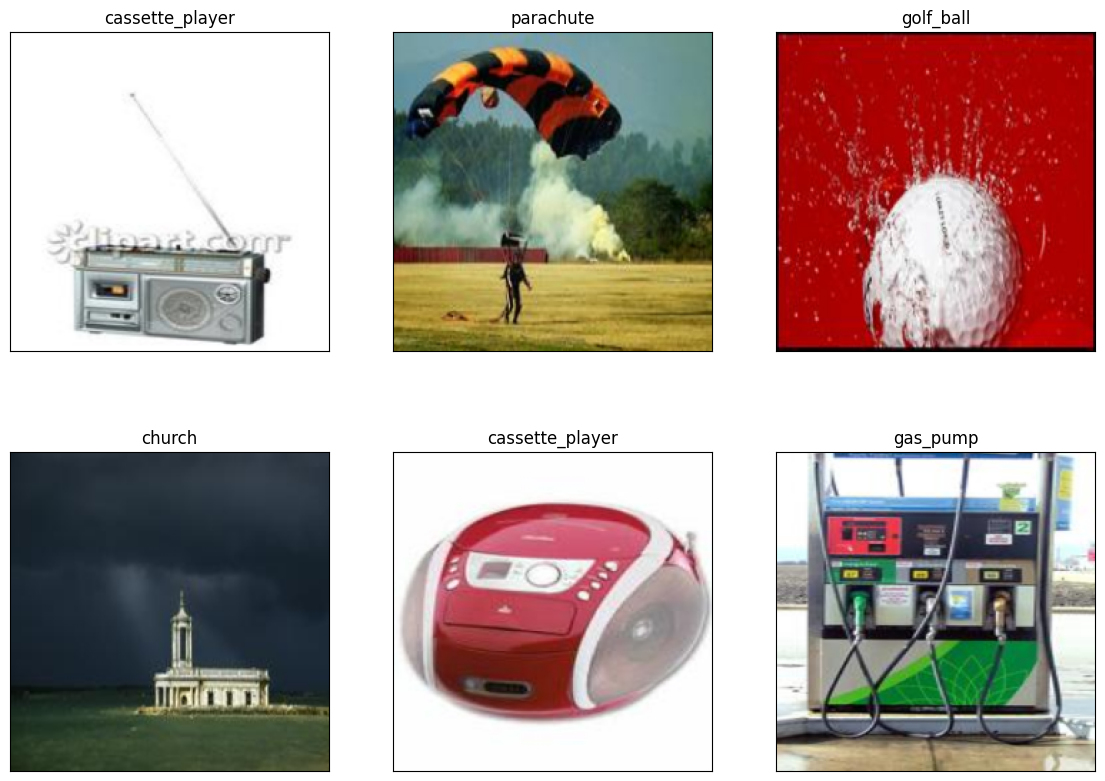

In [83]:
# visualize some data points
traindata,trainlabel = next(iter(trainloader))
labels = os.listdir("../data/imagenette2-160/train")

fig = plt.figure(figsize=(14,10))
fig.tight_layout(pad=6)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(traindata[i].permute(1,2,0)))
    plt.title(labels[trainlabel[i]])

In [84]:
# AlexNet
class AlexNet(nn.Module):
    def __init__(self, outputs, lr, momentum, weight_decay):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.net = nn.Sequential(nn.LazyConv2d(out_channels=96,kernel_size=11,stride=4),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.LazyConv2d(out_channels=256,kernel_size=5,padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.LazyConv2d(out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                                 nn.LazyConv2d(out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                                 nn.LazyConv2d(out_channels=256,kernel_size=3,padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2),
                                 nn.Flatten(),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
                                 nn.LazyLinear(outputs))

    def forward(self, x):
        return self.net(x)

    # cross-entropy loss
    def loss(self, batch):
        logits, labels = batch
        return F.cross_entropy(logits, labels) # mean reduction default

    def accuracy(self, batch, averaged=True):
        logits, labels = batch
        logits, labels = logits.to('cpu'), labels.to('cpu')
        predict = self.predict(logits).type(labels.dtype)
        compare = (predict == labels).type(torch.float32) # bc predict now on cpu
        return compare.mean() if averaged else compare

    def predict(self, logits):
        return logits.argmax(axis=1) # issue w argmax on gpu

    def initOptimizer(self):
        self.optim = SGD(self.parameters(), self.lr, self.momentum, self.weight_decay)

In [86]:
# early stopper and training loop

# early stopping class
# criterion: validation accuracy
class EarlyStop():
    def __init__(self, patience, delta=0.003):
        self.patience = patience
        self.delta = delta
        self.best = 0
        self.count = 0

    def checkForStop(self, acc):
        if acc > self.best:
            self.best = acc
            self.count = 0
            return False
        elif acc < self.best-self.delta:
            if self.count > self.patience:
                return True
            self.count = self.count + 1
            return False
        
# training loop
def train(model, trainloader, valloader, epochs):
    train_loss = []
    val_loss = []
    val_acc = []
    model.initOptimizer()
    mps = torch.device('mps')
    model.to(mps)
    stopper = EarlyStop(3)

    pbar = tqdm(range(epochs))
    for i in range(epochs):
        train_loss.append(0)
        val_loss.append(0)
        val_acc.append(0)

        model.train()
        # training over batches of train set
        for n, (traindata,trainlabel) in enumerate(trainloader):
            traindata, trainlabel = traindata.to(mps), trainlabel.to(mps)
            model.optim.zero_grad()
            logits = model.forward(traindata)
            loss = model.loss((logits,trainlabel))
            loss.backward()
            model.optim.step()

            train_loss[i] = train_loss[i] + loss.item()
        train_loss[i] = train_loss[i] / len(trainloader)

        # validation over batches of val set
        model.eval()
        for n, (val,vallabel) in enumerate(valloader):
            val, vallabel = val.to(mps), vallabel.to(mps)
            with torch.no_grad():
                logits = model.forward(val)
                loss = model.loss((logits,vallabel))
                accuracy = model.accuracy((logits,vallabel))

                val_loss[i] = val_loss[i] + loss.item()
                val_acc[i] = val_acc[i] + accuracy
        val_loss[i] = val_loss[i] / len(valloader)
        val_acc[i] = val_acc[i] / len(valloader)

        # update pbar
        pbar.update(1)
        pbar.set_description(f'val_acc: {val_acc[i]:.3f} train_loss: {train_loss[i]:.3f}')

        # check for early stopping
        if stopper.checkForStop(val_acc[i]):
            break

    pbar.close()

    # display loss and acc
    #plt.plot(train_loss, label='train_loss')
    #plt.plot(val_loss, label='val_loss')
    plt.plot(val_acc)
    plt.xlabel('epoch')
    #plt.legend()

In [106]:
# initialize model
mps = torch.device('mps')
model = AlexNet(10,lr=0.1,momentum=0.5,weight_decay=0.01)
model.to('mps')

AlexNet(
  (net): Sequential(
    (0): LazyConv2d(0, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): LazyLinear(in_features=0, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): LazyLinear(in_features=0, out_features=4096, bias=True)
    (18): ReLU()
    (1

val_acc: 0.564 train_loss: 1.865:  49%|████▉     | 49/100 [1:10:56<1:13:50, 86.87s/it] 


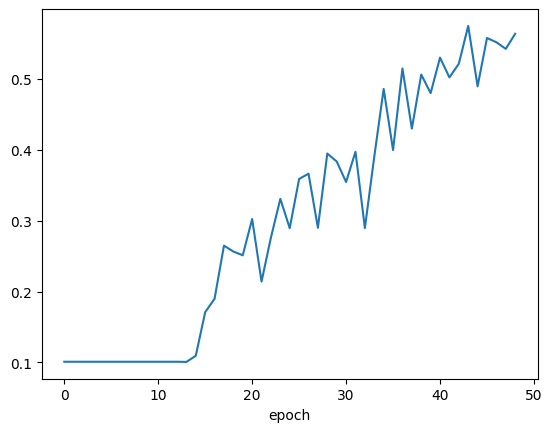

In [107]:
# train
train(model,trainloader,valloader,100)

val_acc: 0.640 train_loss: 1.699: 100%|██████████| 50/50 [1:17:44<00:00, 93.29s/it] 


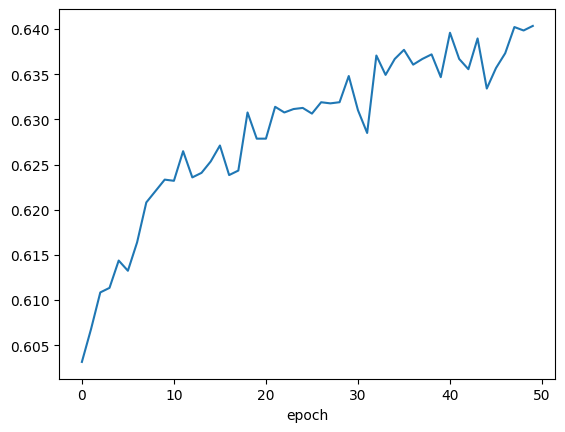

In [111]:
# adjust learning rate and continue training
model.lr = 0.01
train(model,trainloader,valloader,50)

Fluctuating validation accuracy suggests learning rate is still too high.

val_acc: 0.671 train_loss: 1.615: 100%|██████████| 5/5 [09:22<00:00, 112.50s/it]


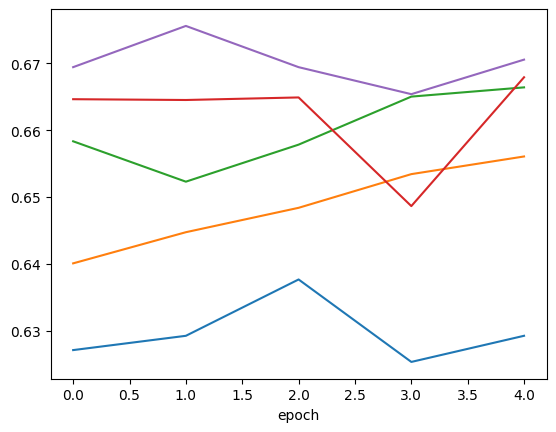

In [112]:
# mock learning rate schedule, -8% lr every 5 epochs for additional 25 epochs, motivated by Inception paper
# also reset momentum and weight decay to original AlexNet paper params
model.momentum = 0.9
model.weight_decay = 0.0005
for i in range(5):
    model.lr = model.lr*0.92
    train(model,trainloader,valloader,5)

Validation accuracy 0.671 after 75 epochs. Can likely train longer at each learning rate to improve scores.  
  
For the future, implement image augmentations such as random horizontal and vertical flipping, cropping, random RGB intensities etc. Image augmentations will expand the training dataset, add noise to reduce overfitting, and help the model generalize better and achieve higher validation scores.  
  
Can also experiment with different implementations of learning rate scheduler since academic papers only seem to reduce the learning rate three times. Maybe use optimizers with variable learning rates.

In [115]:
# classification metrics
def classification_metrics(true, pred, labels=None):
    # turn tensors to arrays, make sure same type
    true, pred = np.array(true).astype(int), np.array(pred).astype(int) 
    
    # create confusion matrix
    cm = confusion_matrix(true,pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(xticks_rotation='vertical')

    # TP,TN,FP,FN
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    # precision and recall by class
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)

    # macro averaged precision and recall
    N = len(precision)
    macro_precision = np.sum(precision) / N
    macro_recall = np.sum(recall) / N

    # micro averaged precision and recall
    micro_precision = np.sum(tp) / (np.sum(tp)+np.sum(fp))
    micro_recall = np.sum(tp) / (np.sum(tp)+np.sum(fn))

    # accuracy by class
    class_accuracy = (tp+tn) / (tp+fn+fp+tn)

    # overall accuracy
    accuracy = (true == pred).mean()

    # print metrics
    if labels is None:
        labels = np.unique(true)
    print(f' Class: \t\t Accuracy: \t\t Precision: \t\t Recall: \t\t')
    for i in range(N):
        print(f'  {labels[i]}: \t\t\t {class_accuracy[i]:.3f}\t\t\t {precision[i]:.3f}\t\t\t {recall[i]:.3f}')
    print(f'\n Overall Accuracy: \t{accuracy:.3f}')
    print(f' Macro Precision: \t{macro_precision:.3f} \t\t Micro Precision: \t{micro_precision:.3f}')
    print(f' Macro Recall: \t\t{macro_recall:.3f} \t\t Micro Recall: \t\t{micro_recall:.3f}')

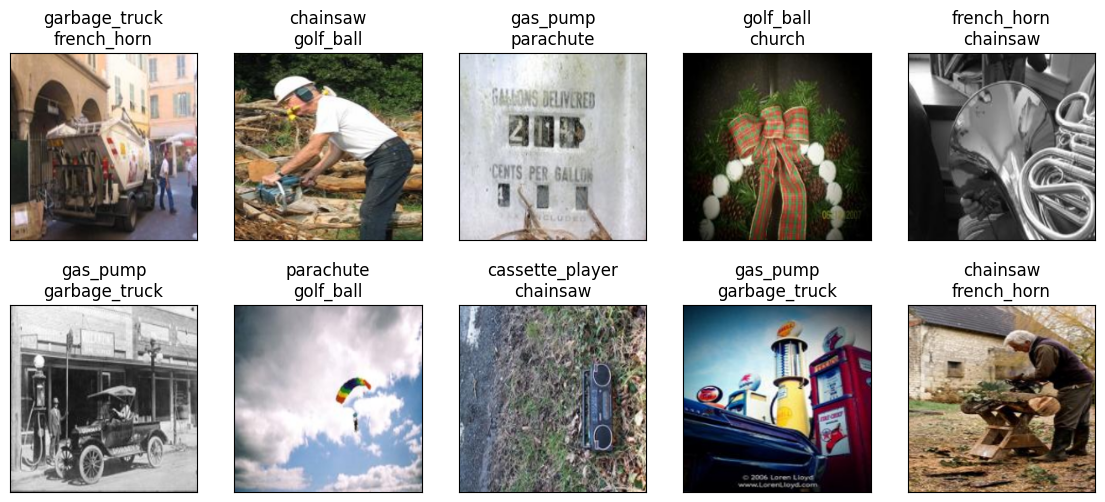

In [126]:
# where did model fail
valloader2 = DataLoader(val,500,True)
testdata, testlabel = next(iter(valloader2))

model.to('cpu')
model.eval()
logits = model.forward(testdata)
pred = model.predict(logits)

missed_idx = np.array((pred != testlabel).type(torch.float32))
missed_idx = np.where(missed_idx == 1)

missed = (testdata[missed_idx], testlabel[missed_idx], pred[missed_idx])

fig = plt.figure(figsize=(14,6))
fig.tight_layout(pad=3)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(missed[0][i].permute(1,2,0)))
    plt.title(labels[missed[1][i].item()] + '\n' + labels[missed[2][i]])

 Class: 		 Accuracy: 		 Precision: 		 Recall: 		
  chainsaw: 			 0.898			 0.378			 0.333
  gas_pump: 			 0.932			 0.720			 0.643
  tench: 			 0.956			 0.776			 0.833
  french_horn: 			 0.922			 0.603			 0.686
  church: 			 0.946			 0.744			 0.667
  english_springer: 			 0.940			 0.667			 0.723
  golf_ball: 			 0.934			 0.650			 0.765
  garbage_truck: 			 0.954			 0.816			 0.741
  parachute: 			 0.958			 0.745			 0.826
  cassette_player: 			 0.956			 0.837			 0.706

 Overall Accuracy: 	0.698
 Macro Precision: 	0.694 		 Micro Precision: 	0.698
 Macro Recall: 		0.692 		 Micro Recall: 		0.698


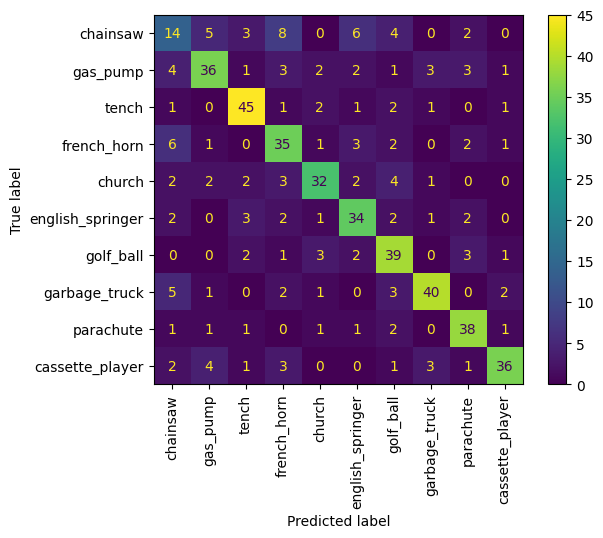

In [127]:
# display classification metrics
classification_metrics(testlabel,pred,labels=labels)

Note when training: chainsaw class has worst scores. Include image augmentations for this class?  
  
Would dropout at the output layer help this model in the same manner as FashionMNIST?

In [129]:
# checkpointing parameters for future experimentation
torch.save(model.state_dict(),'ImagenetteAlexNet_122523.params')